# Logistic Regression

## Introduction
Logistic Regression is a popular model used for classification  tasks, in particular due to its efficiency in handling text based data. It is an algorithm which estimates probabilities using a linear decision boundary, which makes it easier to implement and interpret than other complicated models.

## Applications
- Classification problems
- Binary and multi-class scenarios
- Common use cases (e.g., spam detection, medical diagnosis)


In [1]:
import os
import json
import time
import random
import zipfile
import requests
import pandas as pd
from bs4 import BeautifulSoup

## Reading the Data

In [2]:
data=pd.read_csv('/Users/salmanajmal/Desktop/ML/GroupNo_Project/combined_articles.csv')
data.head()

labels=data['gold_label']
labels=labels.unique()

content=data['content']


## Data Cleaning
This is a custom function to clean urdu texts. A dictionary is made, comprising of common Urdu stopwords, which are then removed and filtered by the using of the regix library.

In [3]:
import re
df = pd.DataFrame(data)

def preprocessing_urdu_text(text):
    stop_words = {
        'کا', 'کی', 'کے', 'نے', 'میں', 'سے', 'پر', 'اور', 'کہ', 
        'جو', 'کہ', 'تو', 'ہے', 'تھا', 'ہوا', 'ہی', 'کیا', 'اس', 
        'یہ', 'نہیں', 'بھی', 'مگر', 'لیکن', 'وہ', 'ہم', 'تم', 'یہاں', 
        'وہاں', 'سب', 'کچھ', 'نیا', 'پہلے', 'جب', 'تاکہ', 'وہی', 
        'کیوں', 'کس', 'ایک', 'دو', 'تیس', 'چند', 'بہت', 'کم', 'زیادہ', 
        'کے', 'میں', 'پر', 'نے', 'دیکھ', 'کا', 'کیا', 'آپ', 'یہ', 'تو', 
        'یہ', 'سے', 'ہے', 'کا', 'سب', 'کیا', 'آئی', 'نہ', 'ہے', 'کی'
    }
    only_urdu_text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    lowercase_text = only_urdu_text.lower()
    tokens = lowercase_text.split()
    filtered_tokens = []
    for token in tokens:
        if token not in stop_words:
            filtered_tokens.append(token)
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

content = content.fillna('')
content = content.astype(str)
processed_content = content.apply(preprocessing_urdu_text)
df['content'] = processed_content
print(df['content'])



0       بالی ووڈ دبنگ خان ممبئی موجود شاہ رخ خان پرتعی...
1       شہرت بلندیوں کو چھونے والے بالی ووڈ اداکار پرب...
2       آرٹس کونسل آف پاکستان کراچی زیر اہتمام روزہ عو...
3       پاکستان شوبز اداکار ہدایتکار یاسر نواز کو سوشل...
4       پاکستان شوبز اداکارہ مہوش حیات بھارتی ریپر و گ...
                              ...                        
1139    ایکس مالک ایلون مسک پنسلوینیا عدالت مقدمہ جیت ...
1140    امریکی انتخابات امن و امان الیکشن عملے تشدد خد...
1141    امریکا سعودی عرب ممکنہ سیکیورٹی معاہدے تبادلہ ...
1142    امریکا صدر کون ہوگا، سپر پاور باگ ڈور ہاتھ ہوگ...
1143    افریقہ جزائر کوموروس غیرقانونی تارکین وطن کشتی...
Name: content, Length: 1144, dtype: object


## Using the Bag of Words (BoW) Approach for Feature Extraction


In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df['content'])

X= X.toarray()

feature_words = vectorizer.get_feature_names_out()

bow_df = pd.DataFrame(X, columns=feature_words)

print(bow_df)

      آؤٹ  آئرلینڈ  آئل  آئلز  آئن  آئند  آئندہ  آئٹم  آئی  آئیسولیشن  ...  \
0       0        0    0     0    0     0      0     0    0          0  ...   
1       0        0    0     0    0     0      0     0    0          0  ...   
2       0        0    0     0    0     1      0     0    0          0  ...   
3       0        0    0     0    0     0      0     0    0          0  ...   
4       0        0    0     0    0     0      0     0    0          0  ...   
...   ...      ...  ...   ...  ...   ...    ...   ...  ...        ...  ...   
1139    0        0    0     0    0     0      0     0    0          0  ...   
1140    0        0    0     0    0     0      0     0    0          0  ...   
1141    0        0    0     0    0     0      0     0    0          0  ...   
1142    0        0    0     0    0     0      0     0    0          0  ...   
1143    0        0    0     0    0     0      0     0    0          0  ...   

      یکدم  یکساں  یکسر  یکطرفہ  یکم  یہ  یہودی  یہودیوں  یہی  

## Logistic Regression Functions



In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def compute_loss(X, y, weights, bias):
    m = len(y)
    z = X.dot(weights) + bias 
    predictions = sigmoid(z)
    
    #Cross Entropy Loss
    loss = - (1 / m) * (np.dot(y.T, np.log(predictions)) + np.dot((1 - y).T, np.log(1 - predictions)))
    return loss

def gradient_descent(X, y, weights, bias, learning_rate, num_iterations):
    m, n = X.shape
    losses = []
    
    for i in range(num_iterations):
        z = X.dot(weights) + bias
        predictions = sigmoid(z)
        error = predictions - y
        
        dw = X.T.dot(error) / m
        db = np.sum(error) / m
        
        weight_update = learning_rate * dw
        bias_update = learning_rate * db
        
        weights = weights - weight_update
        bias = bias - bias_update
        
        loss = compute_loss(X, y, weights, bias)
        losses.append(loss)
        
        if i % 50 == 0:
            print(f"Loss at Iteration {i} = {loss}")
    
    return weights, bias, losses



def predict(X, weights, bias):
    scores = X.dot(weights) + bias  
    probabilities = sigmoid(scores)
    return np.argmax(probabilities, axis=1)



## One vs All (OvA) model

In [6]:
def one_vs_rest_logistic_regression(X, y, num_classes, learning_rate=0.01, num_iterations=1000):
    m, n = X.shape
    weights = np.zeros((n, num_classes))
    bias = np.zeros(num_classes)
    all_losses = []
    
    for c in range(num_classes):
        print(f"Training for class {c}")
        
        y_c = np.zeros_like(y)  
        for i in range(len(y)):          #BasicAlly this makes everything else 0 and that class 1 for binary classification at that instance. There are a total of 5 classes and a run for each class
            if y[i] == c:
                y_c[i] = 1
            else:
                y_c[i] = 0
    
        w = np.zeros(n)
        b = 0
        w, b, losses = gradient_descent(X, y_c, w, b, learning_rate, num_iterations)
        for j in range(n):      
            weights[j, c] = w[j] 
        bias[c] = b
        all_losses.append(losses)
    
    return weights, bias, all_losses

## Training & Testing

Training for class 0
Loss at Iteration 0 = 0.6275130247378846
Loss at Iteration 50 = 0.2973754729822863
Loss at Iteration 100 = 0.22876268606961675
Loss at Iteration 150 = 0.19130307935770882
Loss at Iteration 200 = 0.16681214355834312
Loss at Iteration 250 = 0.14926427167059178
Loss at Iteration 300 = 0.13595666104920529
Loss at Iteration 350 = 0.12544298913098897
Loss at Iteration 400 = 0.11687354514859655
Loss at Iteration 450 = 0.10971764167516115
Loss at Iteration 500 = 0.10362691392530332
Loss at Iteration 550 = 0.09836260971714755
Loss at Iteration 600 = 0.09375493592065495
Loss at Iteration 650 = 0.08967931380550904
Loss at Iteration 700 = 0.08604192299989519
Loss at Iteration 750 = 0.08277054898839531
Loss at Iteration 800 = 0.07980857571798373
Loss at Iteration 850 = 0.07711091309693704
Loss at Iteration 900 = 0.07464115697464792
Loss at Iteration 950 = 0.07236955972695806
Training for class 1
Loss at Iteration 0 = 0.6473110299446306
Loss at Iteration 50 = 0.31734474830591414

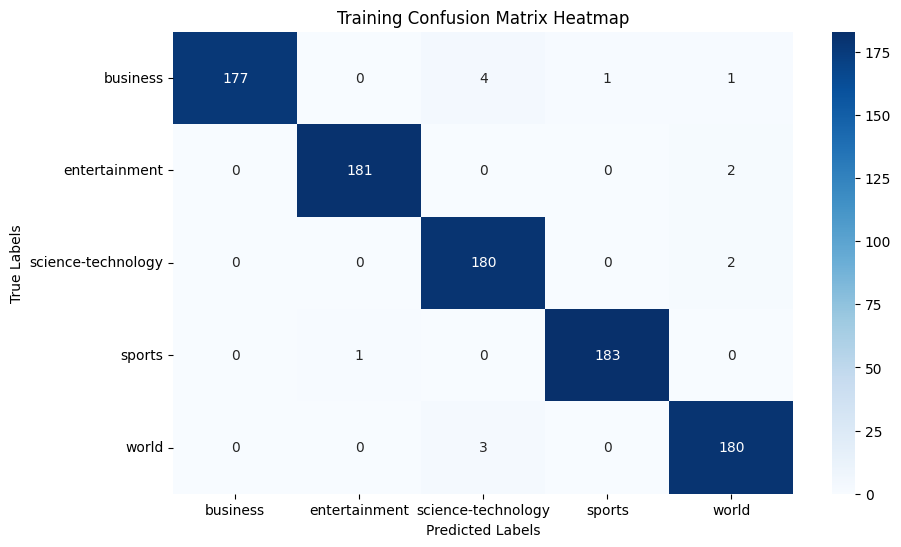

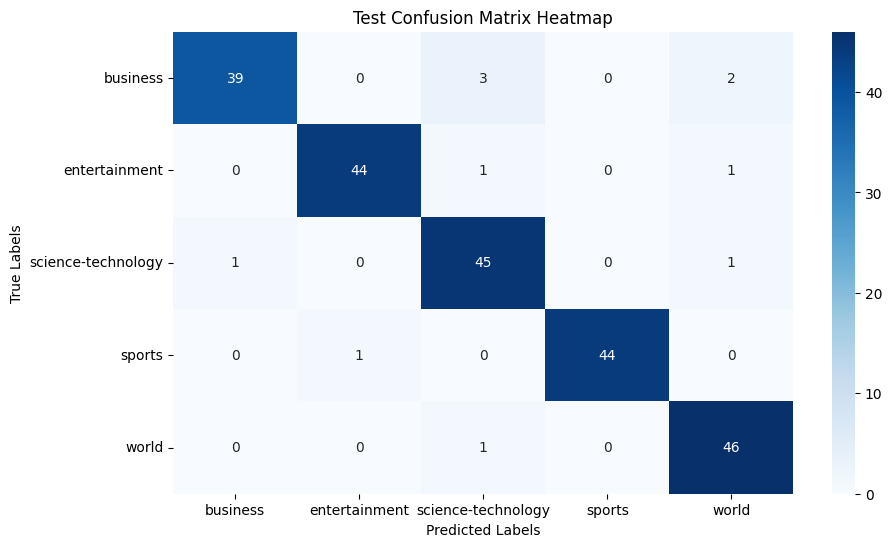

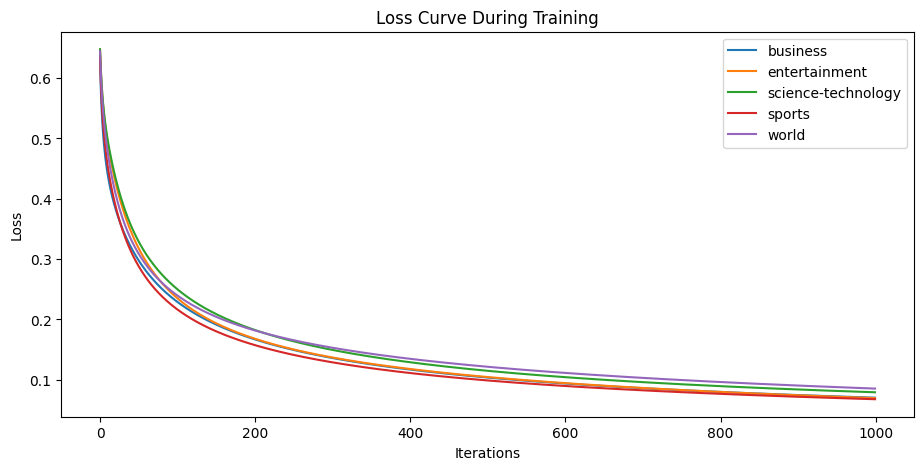

In [7]:

le = LabelEncoder()
y_encoded = le.fit_transform(df['gold_label'])
class_names = le.classes_


X_train, X_test, y_train, y_test = train_test_split(bow_df.values, y_encoded, test_size=0.2, random_state=42)


X_train = csr_matrix(X_train)
X_test = csr_matrix(X_test)


weights, bias, all_losses = one_vs_rest_logistic_regression(X_train, y_train, len(class_names), learning_rate=0.01, num_iterations=1000)


y_pred_train = predict(X_train, weights, bias)
y_pred_test = predict(X_test, weights, bias)


y_pred_train_original = le.inverse_transform(y_pred_train)
y_test_original = le.inverse_transform(y_train)  

y_pred_test_original = le.inverse_transform(y_pred_test)
y_test_test_original = le.inverse_transform(y_test) 


train_accuracy = accuracy_score(y_test_original, y_pred_train_original)
test_accuracy = accuracy_score(y_test_test_original, y_pred_test_original)



print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

print("\nTraining Classification Report:")
print(classification_report(y_test_original, y_pred_train_original))

print("\nTest Classification Report:")
print(classification_report(y_test_test_original, y_pred_test_original))

train_conf_matrix = confusion_matrix(y_test_original, y_pred_train_original)
test_conf_matrix = confusion_matrix(y_test_test_original, y_pred_test_original)

print(train_conf_matrix)
print(test_conf_matrix)
plt.figure(figsize=(10, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Training Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


plt.figure(figsize=(10, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Test Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


plt.figure(figsize=(11,5 ))
for i, losses in enumerate(all_losses):
    plt.plot(losses, label=f"{class_names[i]}")
plt.title("Loss Curve During Training")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Repearing with Ridge (L2) and Lasso (L1) Regularisation

### L1 Regularization

**L1 regularization** is a technique used to prevent overfitting and encourage sparsity in model weights. It adds a penalty proportional to the absolute value of the coefficients to the loss function.

### L2 Regularization

**L2 regularization** adds a penalty proportional to the square of the model's coefficients, preventing large weights but allowing non-zero values.


In [8]:
# Gradient Descent with Ridge (L2) Regularization
def gradient_descent_ridge(X, y, weights, bias, learning_rate, num_iterations, alpha):
    m, n = X.shape
    losses = []

    for i in range(num_iterations):
        z = X.dot(weights) + bias  
        predictions = sigmoid(z)
        
        dw = (X.T.dot(predictions - y) / m) + (alpha / m) * weights
        db = np.sum(predictions - y) / m

        weights = weights -learning_rate * dw
        bias = bias -learning_rate * db

        
        loss = compute_loss(X, y, weights, bias) + (alpha / (2 * m)) * np.sum(np.square(weights))
        losses.append(loss)

        if i % 100 == 0:
            print(f"Iteration {i}: Loss = {loss}")

    return weights, bias, losses


# Gradient Descent with Lasso (L1) Regularization
def gradient_descent_lasso(X, y, weights, bias, learning_rate, num_iterations, alpha):
    m, n = X.shape
    losses = []

    for i in range(num_iterations):
        z = X.dot(weights) + bias  
        predictions = sigmoid(z)

        dw = (X.T.dot(predictions - y) / m) + (alpha / m) * np.sign(weights)
        db = np.sum(predictions - y) / m


        weights = weights- learning_rate * dw
        bias = bias -learning_rate * db

        loss = compute_loss(X, y, weights, bias) + (alpha / m) * np.sum(np.abs(weights))
        losses.append(loss)

        if i % 100 == 0:
            print(f"Iteration {i}: Loss = {loss}")

    return weights, bias, losses


## One vs All (OvA) for L1 and L2 Regularisation

Training for class 0 with ridge regularization
Iteration 0: Loss = 0.6275134144787783
Iteration 100: Loss = 0.22899482870493423
Iteration 200: Loss = 0.16726941149730556
Iteration 300: Loss = 0.13661352127493093
Iteration 400: Loss = 0.11771011811497405
Iteration 500: Loss = 0.10462822616648162
Iteration 600: Loss = 0.09490910898605573
Iteration 700: Loss = 0.08733918277192369
Iteration 800: Loss = 0.08124069393586208
Iteration 900: Loss = 0.07620107979386002
Training for class 1 with ridge regularization
Iteration 0: Loss = 0.647311297951987
Iteration 100: Loss = 0.23507650390389065
Iteration 200: Loss = 0.16839373986133732
Iteration 300: Loss = 0.13753535774556266
Iteration 400: Loss = 0.11868854080634944
Iteration 500: Loss = 0.10552822634699334
Iteration 600: Loss = 0.09560717601172386
Iteration 700: Loss = 0.0877558446639422
Iteration 800: Loss = 0.08133294779506291
Iteration 900: Loss = 0.07595136424681001
Training for class 2 with ridge regularization
Iteration 0: Loss = 0.64790

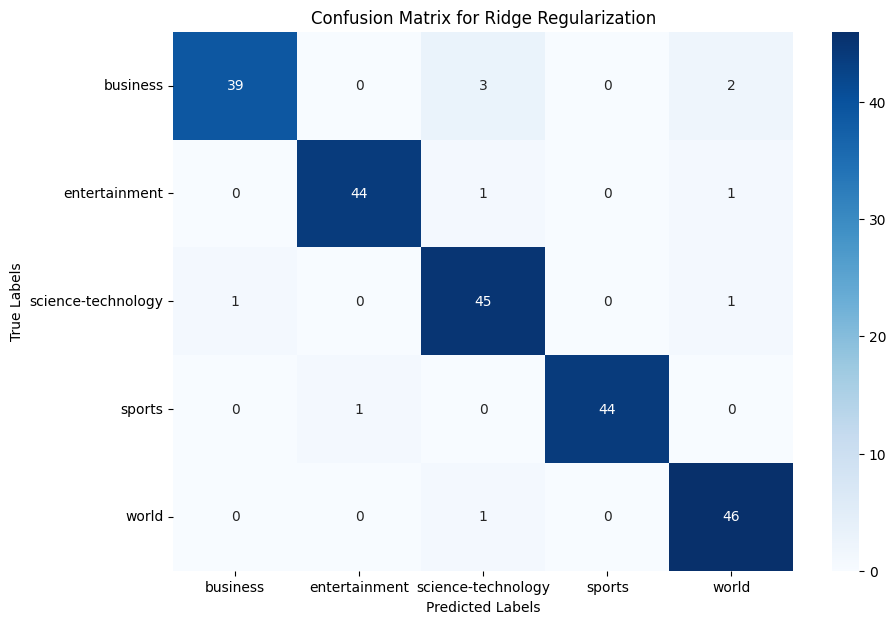

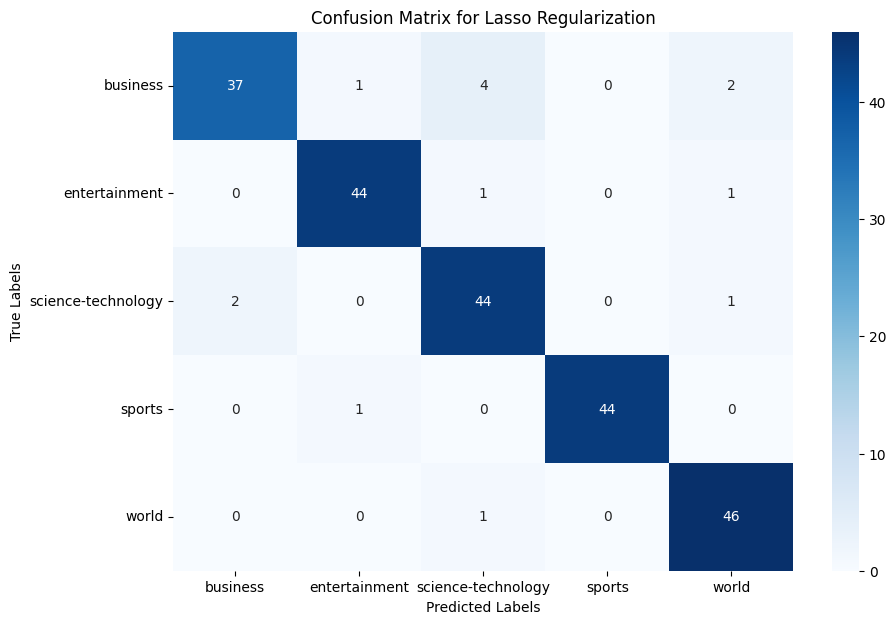

In [9]:

def one_vs_rest_with_regularization(X, y, num_classes, regularization="ridge", alpha=1.0, learning_rate=0.01, num_iterations=1000):
    m, n = X.shape
    weights = np.zeros((n, num_classes))
    bias = np.zeros(num_classes)
    all_losses = []
    
    for c in range(num_classes):
        print(f"Training for class {c} with {regularization} regularization")
        y_c = np.zeros_like(y)
        for i in range(len(y)):
            if y[i] == c:
                y_c[i] = 1
            else:
                y_c[i] = 0
        
        w = np.zeros(n)
        b = 0
        
        if regularization == "ridge":
            w, b, losses = gradient_descent_ridge(
                X=X, 
                y=y_c, 
                weights=w, 
                bias=b, 
                learning_rate=learning_rate, 
                num_iterations=num_iterations, 
                alpha=alpha
            )
        elif regularization == "lasso":
            w, b, losses = gradient_descent_lasso(
                X=X, 
                y=y_c, 
                weights=w, 
                bias=b, 
                learning_rate=learning_rate, 
                num_iterations=num_iterations, 
                alpha=alpha
            )
        else:
            raise ValueError("Regularization type must be 'ridge' or 'lasso'.")
        
        for j in range(n):
            weights[j, c] = w[j]
        bias[c] = b
        all_losses.append(losses)
    
    return weights, bias, all_losses



weights_ridge, bias_ridge, losses_ridge = one_vs_rest_with_regularization( X_train, y_train, len(class_names), regularization="ridge", alpha=1.0, learning_rate=0.01, num_iterations=1000)


weights_lasso, bias_lasso, losses_lasso = one_vs_rest_with_regularization(X_train, y_train, len(class_names), regularization="lasso", alpha=1.0, learning_rate=0.01, num_iterations=1000)


y_pred_test_ridge = predict(X_test, weights_ridge, bias_ridge)
y_pred_test_lasso = predict(X_test, weights_lasso, bias_lasso)


print("\nClassification Report for Ridge Regularization:")
print(classification_report(y_test, y_pred_test_ridge))

print("\nClassification Report for Lasso Regularization:")
print(classification_report(y_test, y_pred_test_lasso))

conf_matrix_ridge = confusion_matrix(y_test, y_pred_test_ridge)
conf_matrix_lasso = confusion_matrix(y_test, y_pred_test_lasso)

print("\nConfusion Matrix for Ridge Regularization:")
print(conf_matrix_ridge)

print("\nConfusion Matrix for Lasso Regularization:")
print(conf_matrix_lasso)


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_ridge, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for Ridge Regularization")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_lasso, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for Lasso Regularization")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()